# 프로젝트 1: 손수 설계하는 선형회귀, 당뇨병 수치를 맞춰보자!

## 개요
- sklearn의 당뇨병 데이터셋을 사용한 선형회귀 모델 직접 구현
- 목표: MSE 손실함수값 3000 이하 달성

## (1) 데이터 가져오기
sklearn.datasets의 load_diabetes에서 데이터를 가져옵니다.

In [1]:
from sklearn.datasets import load_diabetes

data = load_diabetes()
df_X = data.data
df_y = data.target

print("특성 이름:", data.feature_names)
print("데이터 shape:", df_X.shape)
print("타겟 shape:", df_y.shape)

특성 이름: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
데이터 shape: (442, 10)
타겟 shape: (442,)


## (2) 모델에 입력할 데이터 X 준비하기
df_X를 numpy array로 변환합니다.

In [2]:
import numpy as np

X = np.array(df_X)

print(type(X), X.dtype)

<class 'numpy.ndarray'> float64


## (3) 모델에 예측할 데이터 y 준비하기
df_y를 numpy array로 변환합니다.

In [3]:
y = np.array(df_y)

print(type(y), y.dtype)

<class 'numpy.ndarray'> float64


## (4) train 데이터와 test 데이터로 분리하기
데이터를 학습용 80%, 테스트용 20%로 분리합니다.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (353, 10) y_train: (353,)
X_test: (89, 10) y_test: (89,)


## (5) 모델 준비하기
### 가중치(W)와 편향(b) 초기화
- W: 10개의 특성에 대한 가중치 벡터
- b: 편향(bias) 스칼라값

In [5]:
np.random.seed(42)  # 재현성을 위한 시드 설정
W = np.random.rand(X_train.shape[1])
b = np.random.rand()

print("가중치 개수:", len(W))
print("초기 W:", W)
print("초기 b:", b)

가중치 개수: 10
초기 W: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]
초기 b: 0.020584494295802447


### 모델 함수 정의
선형 회귀 모델: $y = X \cdot W + b$

각 특성에 대해 가중치를 곱하고 합산한 후 편향을 더합니다.

In [6]:
def model(X, W, b):
    """
    선형 회귀 모델 함수
    
    Parameters:
        X: 입력 데이터 (N x features)
        W: 가중치 벡터 (features,)
        b: 편향 스칼라
    
    Returns:
        predictions: 예측값 (N,)
    """
    predictions = 0
    for i in range(len(W)):
        predictions += X[:, i] * W[i]  # 모든 행에 대해 i번째 열(특징)을 가져와서 i번째 가중치를 곱함
    predictions += b  # 가중치 합산 후 편향을 더함
    return predictions

## (6) 손실함수 loss 정의하기
### MSE (Mean Squared Error) 함수
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_{pred} - y_{true})^2$$

예측값과 실제값 차이의 제곱 평균을 계산합니다.

In [7]:
def MSE(a, b):
    """
    평균 제곱 오차 (Mean Squared Error)
    """
    mse = ((a - b) ** 2).mean()
    return mse

def loss(X, W, b, y):
    """
    손실 함수 - MSE를 사용하여 예측값과 실제값의 차이를 계산
    """
    predictions = model(X, W, b)  # 모델이 예측한 결과값
    L = MSE(predictions, y)       # 평균제곱 오차: 예측값과 실제값 사이의 오차
    return L

print("초기 손실값:", loss(X_train, W, b, y_train))

초기 손실값: 29690.148098165915


## (7) 기울기를 구하는 gradient 함수 구현하기
### 경사하강법 (Gradient Descent)
MSE 손실함수의 미분:
$$\frac{\partial L}{\partial W} = \frac{2}{N} X^T (y_{pred} - y)$$
$$\frac{\partial L}{\partial b} = \frac{2}{N} \sum(y_{pred} - y)$$

In [8]:
def gradient(X, W, b, y):
    """
    경사하강법을 위한 기울기 계산 함수
    
    Parameters:
        X: 입력 데이터
        W: 가중치
        b: 편향
        y: 실제값
    
    Returns:
        dW: W에 대한 기울기
        db: b에 대한 기울기
    """
    N = len(y)
    y_pred = model(X, W, b)
    
    dW = 1/N * 2 * X.T.dot(y_pred - y)  # W에 대한 편미분
    db = 2 * (y_pred - y).mean()         # b에 대한 편미분
    
    return dW, db

## (8) 하이퍼 파라미터인 학습률 설정하기
학습률(Learning Rate)은 경사하강법에서 한 번에 이동하는 크기를 결정합니다.
- 너무 크면: 발산할 수 있음
- 너무 작으면: 학습이 느려짐

당뇨병 데이터는 이미 정규화되어 있어 비교적 높은 학습률 사용 가능

In [9]:
LEARNING_RATE = 0.5

## (9) 모델 학습하기
경사하강법으로 가중치와 편향을 업데이트합니다.
$$W = W - \alpha \cdot \frac{\partial L}{\partial W}$$
$$b = b - \alpha \cdot \frac{\partial L}{\partial b}$$

In [10]:
losses = []
EPOCHS = 2000

for i in range(1, EPOCHS + 1):
    dW, db = gradient(X_train, W, b, y_train)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(X_train, W, b, y_train)
    losses.append(L)
    if i % 200 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 200 : Loss 3441.8514
Iteration 400 : Loss 3093.6449
Iteration 600 : Loss 2978.8231
Iteration 800 : Loss 2933.6385
Iteration 1000 : Loss 2914.6475
Iteration 1200 : Loss 2906.1474
Iteration 1400 : Loss 2902.0691
Iteration 1600 : Loss 2899.9534
Iteration 1800 : Loss 2898.7549
Iteration 2000 : Loss 2898.0065


## (10) test 데이터에 대한 성능 확인하기
학습된 모델을 테스트 데이터에 적용하여 성능을 평가합니다.

In [11]:
prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)

print("Test MSE:", mse)
print("목표 MSE (3000 이하):", "달성!" if mse < 3000 else "미달성")

Test MSE: 2880.250644388444
목표 MSE (3000 이하): 달성!


In [12]:
# 추가 성능 지표: R² Score
from sklearn.metrics import r2_score

r2 = r2_score(y_test, prediction)
print("R² Score:", r2)

R² Score: 0.45636690281759706


## (11) 정답 데이터와 예측한 데이터 시각화하기

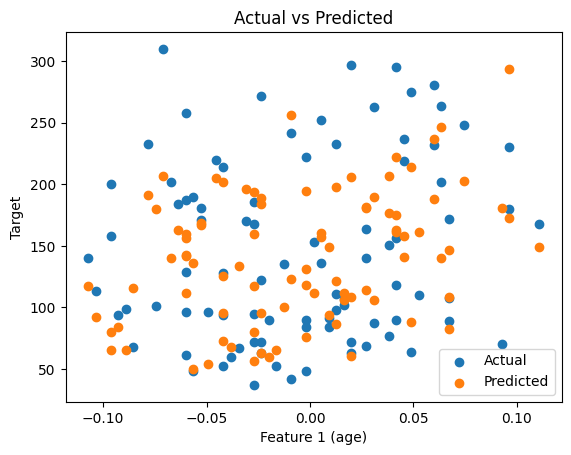

In [13]:
import matplotlib.pyplot as plt

plt.scatter(X_test[:, 0], y_test, label='Actual')
plt.scatter(X_test[:, 0], prediction, label='Predicted')
plt.xlabel('Feature 1 (age)')
plt.ylabel('Target')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

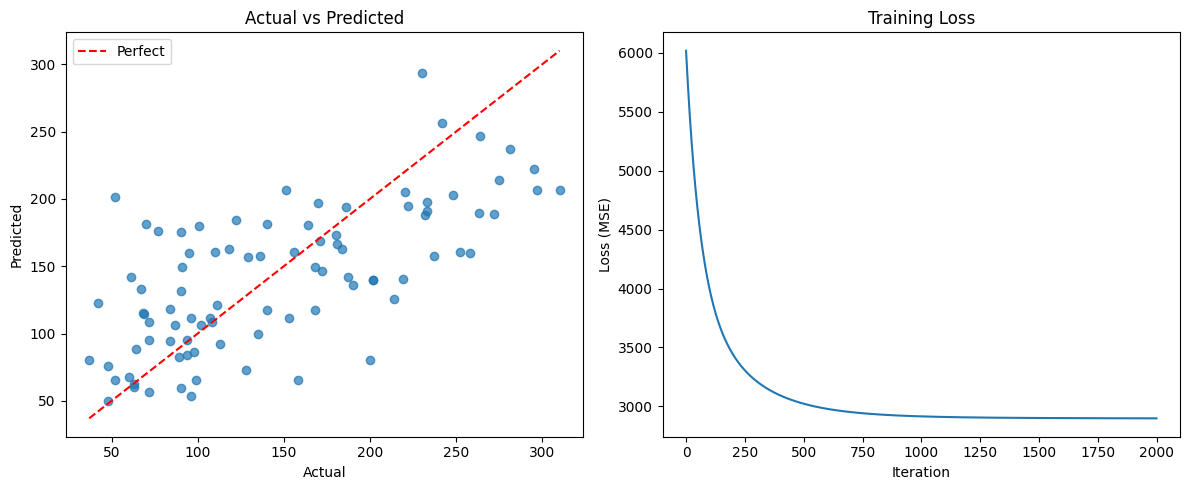

In [14]:
# 추가 시각화: 실제값 vs 예측값 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 그래프 1: 실제값 vs 예측값
axes[0].scatter(y_test, prediction, alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs Predicted')
axes[0].legend()

# 그래프 2: 손실값 변화
axes[1].plot(losses)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_title('Training Loss')

plt.tight_layout()
plt.show()

## 최종 결과 요약

In [15]:
print("="*50)
print("최종 결과 요약")
print("="*50)
print(f"학습된 가중치 W: {W}")
print(f"학습된 편향 b: {b:.4f}")
print(f"Train MSE: {losses[-1]:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print()
print("체크사항:")
print(f"1) 회귀모델 예측정확도 (R²): {r2:.4f}")
print(f"2) MSE 손실함수값 3000 이하: {mse:.4f}", "-> 달성!" if mse < 3000 else "-> 미달성")

최종 결과 요약
학습된 가중치 W: [  39.936947   -236.72215623  550.34121333  340.34476807  -98.14965215
 -127.11860233 -215.74470329  149.03401373  411.07442752   71.8052117 ]
학습된 편향 b: 151.3038
Train MSE: 2898.0065
Test MSE: 2880.2506
R² Score: 0.4564

체크사항:
1) 회귀모델 예측정확도 (R²): 0.4564
2) MSE 손실함수값 3000 이하: 2880.2506 -> 달성!
